In [1]:
import numpy as np
from nozzle import Params, Nozzle, Spectral, Boundary
import matplotlib.pyplot as plt
import os
import re

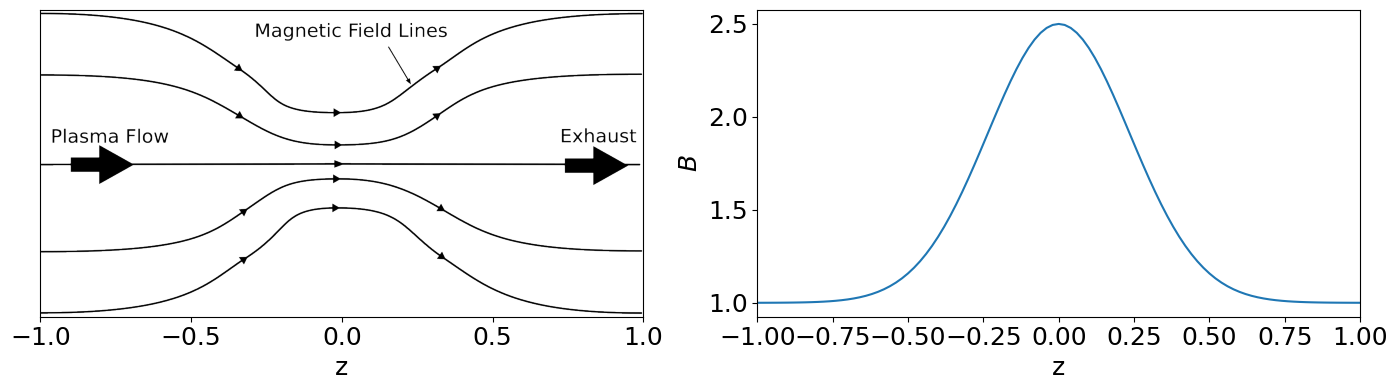

In [3]:
# magnetic field
spectral = Spectral(101, "symmetric", "FD")
params = Params(Mm=0.5, constant_v=False)
B0 = params.B0
R = params.R
Bm = params.Bm
Delta = params.Delta 
x = spectral.x
B = B0*(1+R*np.exp(-(x/Delta)**2))
fig, ax = plt.subplots(1,2,figsize=(14,4))
img = plt.imread("thesis/img/introduction/magnetic-nozzle.png")
ax[1].plot(x,B)
ax[1].set_xlim([-1,1])
ax[1].set_xlabel("z")
ax[1].set_ylabel("$B$")
ax[0].imshow(img, aspect="auto", extent=[-1,1,0,2])
ax[0].set_xticks(ax[1].get_xticks())
ax[0].set_yticks([])
ax[0].set_xlabel("z")
fig.tight_layout()

Text(0.5, 1.0, 'Equilibrium velocity profile')

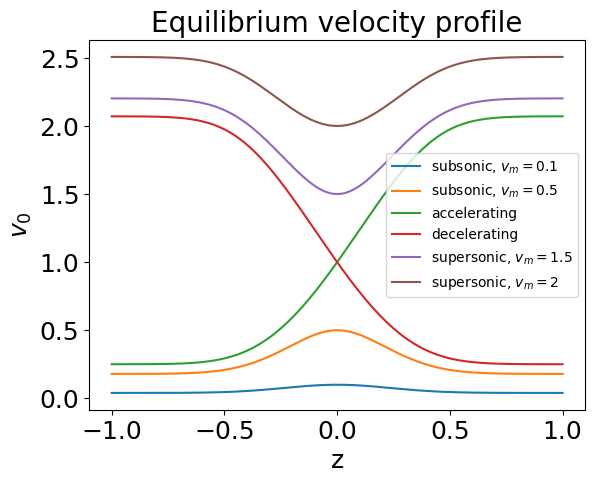

In [2]:
params_list = [
    Params(Mm=0.1, constant_v=False),
    Params(Mm=0.5, constant_v=False),
    Params(Mm=1, accelerating=True),
    Params(Mm=1, accelerating=False),
    Params(Mm=1.5, constant_v=False),
    Params(Mm=2, constant_v=False),
]
x = np.linspace(-1,1,1001)
for params in params_list:
    nozzle = Nozzle(params, x)
    if params.accelerating == True:
        label = "accelerating"
    elif params.accelerating == False:
        label = "decelerating"
    elif params.Mm < 1:
        label = f"subsonic, $v_m={params.Mm}$"
    elif params.Mm > 1:
        label = f"supersonic, $v_m={params.Mm}$"
    plt.plot(x, nozzle.v0, label=label)
plt.legend(fontsize="medium")
plt.xlabel("z")
plt.ylabel("$v_0$")
plt.title("Equilibrium velocity profile")

analytical v_0'(z): 2.3237900077244498
numerical v_0''(z): (1.79998984670965+0j)
numerical v_0'''(z): (-16.731318537495103+0j)


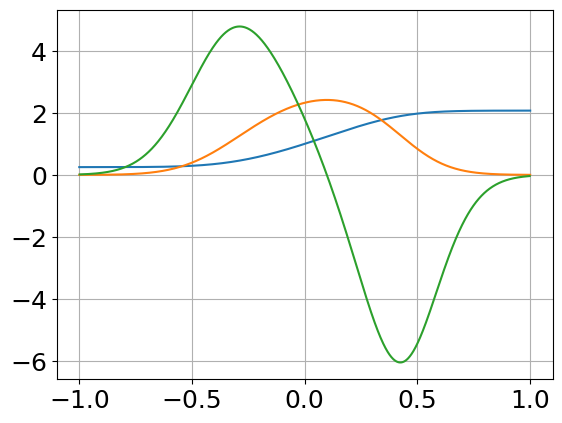

In [4]:
N = 1001
params = Params(Mm=1.0, accelerating=True)
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
nozzle = Nozzle(params, x)
v0 = nozzle.v0
print("analytical v_0'(z):", np.sqrt(params.R/(1+params.R)/params.Delta**2))
print("numerical v_0''(z):", (D2@v0)[500])
print("numerical v_0'''(z):", (D1@(D2@v0))[500])

plt.plot(x, v0)
plt.plot(x, (D1@v0).real)
plt.plot(x[1:-1], (D2@v0).real[1:-1])
plt.grid()

In [5]:
v0[-1]

2.070758636612481

In [25]:
import sympy as sp

In [35]:
z = sp.symbols("z")
B0, R, delta = sp.symbols("B0 R delta", real=True)
B = B0*(1+R*sp.exp(-(z/delta)**2))

In [64]:
v0_p = sp.sqrt((-1/2)*sp.log(B).diff(z,2))
v0_p.subs(z,0)

1.0*sqrt(R/(delta**2*(R + 1)))

# constant velocity

Text(0.5, 1.0, '$M_m=1.0$, accelerating')

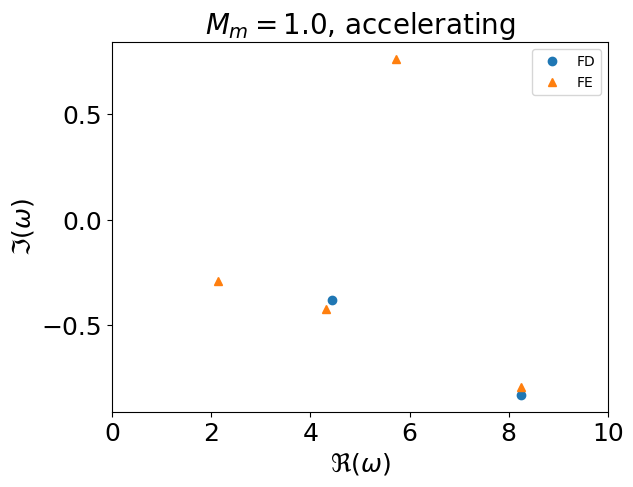

In [62]:
Mm = 1.0
constant_v = False
accelerating = True
boundary = Boundary.FIXED_OPEN
marker = {
    "FD": "o",
    "FE": "^",
    "SE": "s"
}
methods = ["FD", "FE"]

data_dir = os.path.join("data", boundary.value)
if constant_v:
    data_dir = os.path.join(data_dir, "constant_v")
elif (Mm > 1):
    data_dir = os.path.join(data_dir, "supersonic_v")
elif (Mm < 1):
    data_dir = os.path.join(data_dir, "subsonic_v")
elif (Mm == 1):
    if accelerating:
        data_dir = os.path.join(data_dir, "accelerating_v")
    else:
        data_dir = os.path.join(data_dir, "decelerating_v")
datas = os.listdir(data_dir)

for method in methods:
    file = next(filter(lambda name: (method in name) and (f"Mm={Mm}" in name), datas))
    data = np.load(os.path.join(data_dir,file))
    x, omega, V = data["x"], data["omega"], data["V"]
    plt.plot(omega.real, omega.imag, marker[method], label=method)
plt.xlim([0,10])

# omega = np.arange(1,6)*np.pi/2*np.abs(1-Mm**2)
# plt.plot(omega.real, omega.imag, 'x', label="Exact")

# omega = (Mm**2-1)*(2*np.arange(1,6)*np.pi - 1j*np.log((Mm-1)/(Mm+1)+0j))/4
# plt.plot(omega.real, omega.imag, 'x', label="Exact")

plt.legend(fontsize="medium", loc="best")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")
title = f"$M_m={Mm}$"
if (np.isclose(Mm, 1.0)): 
    title += ", accelerating" if accelerating else ", decelerating"
elif constant_v:
    title = f"$v_0={Mm}$"
plt.title(title)


In [40]:
Mm = 0.5
# exact = np.arange(1,10)*np.pi/2*np.abs(1-Mm**2)
exact = (Mm**2-1)*(2*np.arange(0,6)*np.pi - 1j*np.log((Mm-1)/(Mm+1)+0j))/4
data_dir = os.path.join("data", Boundary.FIXED_OPEN.value, "constant_v")
# omega = np.load(os.path.join(data_dir,f"FD_Mm={Mm}_N=501.npz"))["omega"] # FD
omega = np.load(os.path.join(data_dir,f"FE_Mm={Mm}_N=101.npz"))["omega"] # FE_Bspline
# omega = np.load(os.path.join(data_dir,f"SE_Mm={Mm}_N=50.npz"))["omega"] # SE_Sine

exact.real = np.abs(exact.real)
size = min(exact.size, omega.size)
# rel_err_real = np.abs(omega.real[:size]-exact.real[:size])/exact.real[:size]
# rel_err_imag = np.abs(omega.imag[:size]-exact.imag[:size])/exact.imag[:size]
# print("relative error real:", rel_err_real)
# print("relative error imag:", rel_err_imag)
np.abs(omega[:size]-exact[:size])/np.abs(exact[:size])

array([8.08987571e-05, 2.00700827e-04, 2.98094002e-04, 6.59640796e-04,
       1.82059521e-03])

# B-Spline

In [2]:
from scipy.interpolate import BSpline

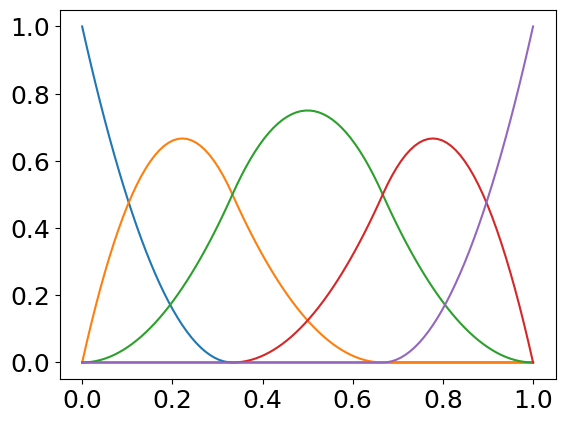

In [84]:
x = np.linspace(0,1,100)
k = 2
t = np.concatenate([np.zeros(k), np.linspace(0,1,4) ,np.ones(k)])
c = np.zeros(t.size-k-1)
c[-1] = 1
for _ in range(t.size-k-1):
    c = np.roll(c,1)
    spl = BSpline(t,c,k)
    plt.plot(x,spl(x))

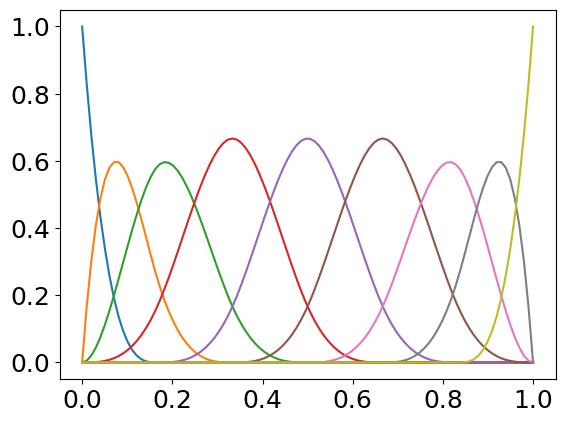

In [82]:
x = np.linspace(0,1,100)
k = 3
t = np.concatenate([np.zeros(k), np.linspace(0,1,7) ,np.ones(k)])
c = np.zeros(t.size-k-1)
c[-1] = 1
for _ in range(t.size-k-1):
    c = np.roll(c,1)
    spl = BSpline(t,c,k)
    plt.plot(x,spl(x))